In [1]:
import pandas as pd
import rustworkx as rx
import numpy as np
from rustworkx.visualization import mpl_draw as draw
from qiskit.quantum_info import SparsePauliOp

# Entrées : fichier csv contenant la matrice d'adjacence avec poids créé avec build_graph.py output mat_adj.csv 
# On pourrait ajouter un paramètre pour donner un nom à la matrice d'adjacence qu'on output 
df = pd.read_csv("mat_adj.csv")
# df.pop("Unnamed: 0")
mat_adj = np.array(df)



C:\Users\harsh\AppData\Local\Temp\ipykernel_20192\728176885.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


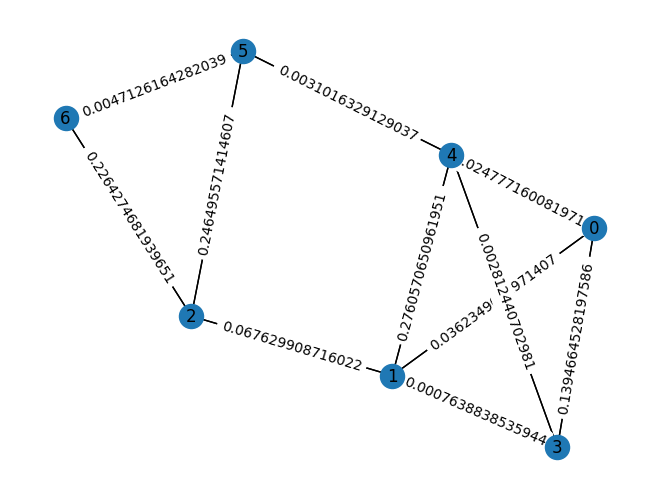

In [2]:
# With the adjacency matrix, we can build a graph : 
graph_cross = rx.PyGraph()
num_nodes_cross_graph = len(df)
nodes_list = graph_cross.add_nodes_from((range(num_nodes_cross_graph)))
# Add edges : 
edges = []
for i in range(num_nodes_cross_graph):
    for j in range(num_nodes_cross_graph):
        if mat_adj[i, j] != 0:
            edges.append((i, j, mat_adj[i, j]))
            
# print(edges)
graph_cross.add_edges_from(edges)

draw(graph_cross, with_labels=True, edge_labels=str) # type: ignore

### Ceci correspond bien aux noeuds correspondant aux deux premières colonnes du fibercup, du noeuds 0 à 6 comptabilisant 7 noeuds au total: 

![Fibercup](Fibercup_m_7.png)

#### Matrice d'adjacence pondérée pour les 7 premiers noeuds du Fibercup: 

$\begin{bmatrix}
0.        & 0.03623491 & 0.           & 0.13946645  & 0.02477716  & 0.          & 0.       \\
0.03623491& 0.         &  0.06762991  & 0.00076388  & 0.27605707  & 0.          & 0.        \\
0.        & 0.06762991 & 0.           & 0.          & 0.          & 0.24649557  & 0.22642747\\
0.13946645& 0.00076388 & 0.           &0.           & 0.00281244  &0.           & 0.        \\
0.02477716& 0.27605707 & 0.           & 0.00281244  & 0.          & 0.00310163  & 0.        \\
0.        &0.          & 0.24649557   & 0.          & 0.00310163  & 0.          & 0.00471262\\
0.        &0.          &0.22642747    & 0.          & 0.          & 0.00471262  & 0.        \\
\end{bmatrix}
$

In [3]:

mat_triang_sup = np.triu(mat_adj)
mat_triang_sup = np.array(mat_triang_sup)


# Déterminer les connexions possibles entre chaque noeud voisin: 
all_possible_connexions = []

for start in range(num_nodes_cross_graph): 
    start_node_adj_mat = mat_adj[start]
    possible_starts = []
    for node,value in enumerate(start_node_adj_mat):
        if value>0:
            possible_starts.append(node)
    all_possible_connexions.extend([possible_starts])
    print(f'Possible connexions from node {start} to node(s) : {possible_starts}')
print(f'Toutes connexions possibles (doublées) : {all_possible_connexions} \n')


# Déterminer le nom des edges: 
list_of_nodes_for_naming_edges = []
destination= []
number_of_edges = 0

for start in range(num_nodes_cross_graph-1): 
    start_node_adj_mat = mat_triang_sup[start]
    end_edge = []
    for node,value in enumerate(start_node_adj_mat):
        if value>0:
            end_edge.append(node)
            number_of_edges+=1 
            destination.append(node)
    list_of_nodes_for_naming_edges.extend([end_edge])
    print(f'Edges from node {start} to node(s) : {end_edge}')
print(f'Toutes connexions sans doublement: {list_of_nodes_for_naming_edges}')

q_indices = []
depart = []
index = 0 
num_nodes_minus_1 = num_nodes_cross_graph - 1
for i in range(num_nodes_minus_1):
    for j in list_of_nodes_for_naming_edges[i]:
        depart.append(i)
        q_indices.append(index)
        index +=1
        
print(f'Indice :{q_indices}')
print(f'Départ :{depart}')
print(f'Destin :{destination}')

weights = []
for a in range(number_of_edges):
    for i in depart:
        for j in destination: 
            weight_qubit = mat_adj[depart,destination]
weights.append(weight_qubit)
weights[0][0]



Possible connexions from node 0 to node(s) : [1, 3, 4]
Possible connexions from node 1 to node(s) : [0, 2, 3, 4]
Possible connexions from node 2 to node(s) : [1, 5, 6]
Possible connexions from node 3 to node(s) : [0, 1, 4]
Possible connexions from node 4 to node(s) : [0, 1, 3, 5]
Possible connexions from node 5 to node(s) : [2, 4, 6]
Possible connexions from node 6 to node(s) : [2, 5]
Toutes connexions possibles (doublées) : [[1, 3, 4], [0, 2, 3, 4], [1, 5, 6], [0, 1, 4], [0, 1, 3, 5], [2, 4, 6], [2, 5]] 

Edges from node 0 to node(s) : [1, 3, 4]
Edges from node 1 to node(s) : [2, 3, 4]
Edges from node 2 to node(s) : [5, 6]
Edges from node 3 to node(s) : [4]
Edges from node 4 to node(s) : [5]
Edges from node 5 to node(s) : [6]
Toutes connexions sans doublement: [[1, 3, 4], [2, 3, 4], [5, 6], [4], [5], [6]]
Indice :[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Départ :[0, 0, 0, 1, 1, 1, 2, 2, 3, 4, 5]
Destin :[1, 3, 4, 2, 3, 4, 5, 6, 4, 5, 6]


0.0362349072971407

In [4]:

all_weights_sum  = sum(np.tril(mat_adj).flatten())

pauli_terms = []
# Terme "IIIIII...I": 
pauli_terms.append(("I" * number_of_edges, all_weights_sum / 2))

# Z à la bonne position: 
for i in range(number_of_edges):
    str = ("I" * (number_of_edges - i - 1) + "Z" + "I" * i, -weights[0][i] / 2)
    pauli_terms.append(str)

pauli_op = SparsePauliOp.from_list(pauli_terms)
pauli_op

SparsePauliOp(['IIIIIIIIIII', 'IIIIIIIIIIZ', 'IIIIIIIIIZI', 'IIIIIIIIZII', 'IIIIIIIZIII', 'IIIIIIZIIII', 'IIIIIZIIIII', 'IIIIZIIIIII', 'IIIZIIIIIII', 'IIZIIIIIIII', 'IZIIIIIIIII', 'ZIIIIIIIIII'],
              coeffs=[ 5.14239554e-01+0.j, -1.81174536e-02+0.j, -6.97332264e-02+0.j,
 -1.23885800e-02+0.j, -3.38149544e-02+0.j, -3.81941927e-04+0.j,
 -1.38028533e-01+0.j, -1.23247786e-01+0.j, -1.13213734e-01+0.j,
 -1.40622035e-03+0.j, -1.55081646e-03+0.j, -2.35630821e-03+0.j])